In [1]:
import folium
import geopandas as gpd
from sentinelsat.sentinel import SentinelAPI
import rasterio 
import matplotlib.pyplot as plt
from rasterio import plot
from rasterio.plot import show
from rasterio.mask import mask
from osgeo import gdal
import earthpy as et

/home/david/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [6]:
roi = gpd.read_file('../data/roi_gdlj.geojson')
print(roi.head())

   id                                           geometry
0   1  MULTIPOLYGON (((-103.38683 20.56446, -103.2610...


In [13]:
footprint = None
for i in roi['geometry']:
    footprint = i
    
user = 'davidmacer'
password = 'wFwKeDESv@TCuK8'
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')
products = api.query(footprint,
                     date = ('20220701', '20220722'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0, 10))

In [35]:
gdf = api.to_geodataframe(products)
gdf_sorted = gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
gdf_sorted

/usr/lib/python3/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,...,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,geometry
2f149dec-aa03-49aa-8d7a-9067a586e4d5,S2B_MSIL2A_20220721T171859_N0400_R012_T13QFC_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2022-07-21T17:18:59.024Z, Instrument: MS...",false,2022-07-21 21:54:46,2022-07-21 17:18:59.024,2022-07-21 17:18:59.024,2022-07-22 01:23:50.369,...,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_2BPS_20220721T215446_S2022...,S2B_OPER_MSI_L2A_TL_2BPS_20220721T215446_A0280...,S2B_MSIL2A_20220721T171859_N0400_R012_T13QFC_2...,2f149dec-aa03-49aa-8d7a-9067a586e4d5,"MULTIPOLYGON (((-102.99722 19.79682, -102.9844..."


In [30]:
gdf_sorted.iloc[0]['uuid']

'2f149dec-aa03-49aa-8d7a-9067a586e4d5'

In [31]:
api.download(gdf_sorted.iloc[0]['uuid'])

Downloading: 100%|██████████| 1.19G/1.19G [03:01<00:00, 6.54MB/s]
MD5 checksumming: 100%|██████████| 1.19G/1.19G [00:18<00:00, 62.8MB/s] 


{'id': '2f149dec-aa03-49aa-8d7a-9067a586e4d5',
 'title': 'S2B_MSIL2A_20220721T171859_N0400_R012_T13QFC_20220721T215446',
 'size': 1187100400,
 'md5': 'a5b97f9bf99d5ac9110888005ace6871',
 'date': datetime.datetime(2022, 7, 21, 17, 18, 59, 24000),
 'footprint': 'POLYGON((-104.03912 20.79755038149346,-102.984436 20.788403082171477,-102.99722 19.796820923140057,-104.04523 19.805495474810392,-104.03912 20.79755038149346))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('2f149dec-aa03-49aa-8d7a-9067a586e4d5')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2022, 7, 22, 1, 24, 25, 126000),
 'Ingestion Date': datetime.datetime(2022, 7, 22, 1, 23, 50, 369000),
 'path': './S2B_MSIL2A_20220721T171859_N0400_R012_T13QFC_20220721T215446.zip',
 'downloaded_bytes': 1187100400}

In [ ]:
# Código para descomprimir
from zipfile import ZipFile

with ZipFile('S2B_MSIL2A_20220721T171859_N0400_R012_T13QFC_20220721T215446.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [2]:
bands = r'./S2B_MSIL2A_20220721T171859_N0400_R012_T13QFC_20220721T215446.SAFE/GRANULE/L2A_T13QFC_A028066_20220721T173238/IMG_DATA/R10m'

In [3]:
os.listdir(bands)

['T13QFC_20220721T171859_TCI_10m.jp2',
 'T13QFC_20220721T171859_WVP_10m.jp2',
 'T13QFC_20220721T171859_AOT_10m.jp2',
 'T13QFC_20220721T171859_B02_10m.jp2',
 'T13QFC_20220721T171859_B03_10m.jp2',
 'T13QFC_20220721T171859_B08_10m.jp2',
 'T13QFC_20220721T171859_B04_10m.jp2']

In [4]:
blue = rasterio.open(bands+'/T13QFC_20220721T171859_B02_10m.jp2') 
green = rasterio.open(bands+'/T13QFC_20220721T171859_B03_10m.jp2') 
red = rasterio.open(bands+'/T13QFC_20220721T171859_B04_10m.jp2')
nir = rasterio.open(bands+'/T13QFC_20220721T171859_B08_10m.jp2')

In [32]:
avi = (nir.read(1)*(1-red.read(1))*(nir.read(1)-red.read(1)))
savi = (nir.read(1)-red.read(1))/(nir.read(1)+red.read(1))
ndvi = (nir.read(1)-red.read(1))/(nir.read(1)+red.read(1))

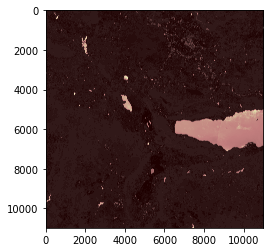

In [9]:
plt.imshow(savi, cmap='pink')

In [31]:
savi

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
savi_filtrado = savi
savi_filtrado[savi_filtrado >= 0.5] = 1
savi_filtrado[savi_filtrado < 0.5] = 0

In [26]:
savi_filtrado

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [1]:
def array_to_raster(raster_array, raster_orig, path_to_save = "./output.tif"):
  import numpy as np
  import rasterio
  from rasterio.crs import CRS
  from rasterio.transform import from_origin

  # Add One Dimension(dst.write needs three dimentions)
  raster_array = np.array([raster_array])

  # Get Some Parameters
  dim = raster_array.shape
  height = dim[1]
  width = dim[2]
  dtype = raster_array.dtype

  # Get EPSG code
  epsg = raster_orig.crs.to_epsg()
  crs = CRS.from_epsg(epsg)

  # Get Sizes
  t = raster_orig.transform
  x_size = t[0]
  y_size = -t[4]

  # Get Upper Left Coordinates
  x_westup, y_westup = blue.xy(0,0)

  # Affine Transformation
  transform = from_origin(west = x_westup, north = y_westup, xsize = x_size, ysize = y_size)

  # Save Raster
  with rasterio.open(path_to_save, "w",
                   driver = "GTiff",
                   height = height,
                   width = width,
                   count = 1,
                   dtype = dtype,
                   crs = crs,
                   trasnform = transform) as dst:
    dst.write(raster_array)
  
  # Load Raster
  raster_loaded = rasterio.open("./output.tif")
  
  return raster_loaded

In [ ]:
savi_raster = array_to_raster(raster_array = savi, raster_orig = blue)

## Recorte de bosques urbanos
Vamos a recortar las zonas dentro de los bosques urbanos usando sus polígonos

In [13]:
bosques = gpd.read_file('../data/bosques_urbanos_jalisco.geojson')

In [30]:
out_img, out_transform = mask(raster=savi, shapes=bosques, crop=True)

TypeError: mask() got an unexpected keyword argument 'raster'